In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here is a detailed explanation of the provided Python code:

### Importing Necessary Libraries
```python
import os
import cv2
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from skimage.metrics import structural_similarity as ssim
```
- **os**: This module provides a way to interact with the operating system, allowing file and directory manipulations.
- **cv2**: OpenCV library for computer vision tasks.
- **numpy (np)**: A library for numerical operations.
- **keras.preprocessing.image**: For loading and preprocessing images.
- **keras.applications.vgg16**: Contains the VGG16 model and preprocessing utilities.
- **keras.models.Model**: Used to define a model that outputs features from a specific layer.
- **skimage.metrics.structural_similarity (ssim)**: For calculating the structural similarity index between images.

### Defining Paths
```python
drive_path = '/content/drive/MyDrive/hdm'
reference_image_path = os.path.join(drive_path, 'reference_ready.png')
```
- drive_path: The base path where images are stored.
- reference_image_path: The path to the reference image used for comparison.

### Loading the VGG16 Model
```python
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)
```
- **base_model**: Loads the pre-trained VGG16 model with weights trained on ImageNet.
- **model**: Creates a new model that outputs features from the 'fc2' layer of VGG16. This layer is chosen for feature extraction.

### Function to Clean the Image
```python
def clean_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cleaned_image = np.zeros_like(image)
    cv2.drawContours(cleaned_image, contours, -1, (255, 255, 255), thickness=cv2.FILLED)
    return cleaned_image
```
- clean_image(image): Converts the image to grayscale, thresholds it to binary, finds contours, and draws these contours on a blank image to create a cleaned version of the input image.

### Function to Resize and Preprocess the Image
```python
def resize_and_preprocess(image, target_size=(224, 224)):
    resized_image = cv2.resize(image, target_size)
    return preprocess_input(np.expand_dims(img_to_array(resized_image), axis=0))
```
- resize_and_preprocess(image, target_size)**: Resizes the image to 224x224 pixels and preprocesses it for VGG16 input.

### Function to Calculate the Difference Percentage Between Two Images
```python
def image_diff_percentage(image1, image2, model):
    cleaned_image1 = clean_image(image1)
    cleaned_image2 = clean_image(image2)
    cleaned_image2 = cv2.resize(cleaned_image2, (image1.shape[1], image1.shape[0]))
    cleaned_image2 = cv2.cvtColor(cleaned_image2, cv2.COLOR_BGR2GRAY) if len(image1.shape) == 2 else cv2.cvtColor(cleaned_image2, cv2.COLOR_BGR2RGB)

    processed_image1 = resize_and_preprocess(cleaned_image1)
    processed_image2 = resize_and_preprocess(cleaned_image2)

    features1 = model.predict(processed_image1)
    features2 = model.predict(processed_image2)

    (_, diff) = ssim(features1.flatten(), features2.flatten(), full=True, data_range=1)
    diff = (diff * 255).astype("uint8")

    percentage_diff = np.mean(diff) / 255 * 100

    result_image = cv2.addWeighted(image1, 1, cleaned_image2, 1, 0)

    return result_image, diff, percentage_diff
```
- image_diff_percentage(image1, image2, model):
  - Cleans both images.
  - Resizes the second image to match the dimensions of the first.
  - Converts the second image to the same color space as the first.
  - Preprocesses both images for VGG16.
  - Extracts features from both images using the model.
  - Computes the structural similarity index (SSIM) between the features.
  - Calculates the difference percentage.
  - Creates a result image by blending the first image and the cleaned second image.

### Loading the Reference Image
```python
reference_image = cv2.imread(reference_image_path)

if reference_image is None:
    print("Error: Unable to load reference image.")
else:
    output_folder = os.path.join(drive_path, "output_images")
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(drive_path):
        if filename.endswith(".png") and filename != "reference_ready.png":
            image_path = os.path.join(drive_path, filename)
            comparison_image = cv2.imread(image_path)

            if comparison_image is not None:
                result_image, diff, difference_percentage = image_diff_percentage(reference_image, comparison_image, model)

                difference_image_path = os.path.join(output_folder, f"difference_image_{filename}")
                cv2.imwrite(difference_image_path, diff)

                print(f"Percentage Difference ({filename}): {difference_percentage:.2f}%")
            else:
                print(f"Error: Unable to load image {filename}.")

print("All comparisons completed.")
```
- reference_image = cv2.imread(reference_image_path): Loads the reference image.
- if reference_image is None: Checks if the reference image was loaded successfully.
- output_folder = os.path.join(drive_path, "output_images"): Defines the output folder path.
- os.makedirs(output_folder, exist_ok=True): Creates the output folder if it doesn't exist.
- for filename in os.listdir(drive_path): Loops through all files in the directory.
  - Checks if the file is a PNG image and not the reference image.
  - Loads the comparison image.
  - If the image is loaded successfully, calculates the difference percentage.
  - Saves the difference image in the output folder.
  - Prints the percentage difference.

This code compares images in a specified directory to a reference image using a pre-trained VGG16 model to extract features and calculate the structural similarity index (SSIM). It cleans, resizes, and preprocesses the images before extracting features. The code then calculates the difference percentage and saves the difference images in an output folder. This process highlights the differences between images in a detailed and automated manner.

In [ ]:
import os
import cv2
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from skimage.metrics import structural_similarity as ssim

# Define the paths
drive_path = '/content/drive/MyDrive/hdm'
reference_image_path = os.path.join(drive_path, 'reference_ready.png')

# Load VGG16 model
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

# Function to clean the image
def clean_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cleaned_image = np.zeros_like(image)
    cv2.drawContours(cleaned_image, contours, -1, (255, 255, 255), thickness=cv2.FILLED)
    return cleaned_image

# Function to resize and preprocess the image
def resize_and_preprocess(image, target_size=(224, 224)):
    resized_image = cv2.resize(image, target_size)
    return preprocess_input(np.expand_dims(img_to_array(resized_image), axis=0))

# Function to calculate the difference percentage between two images
def image_diff_percentage(image1, image2, model):
    cleaned_image1 = clean_image(image1)
    cleaned_image2 = clean_image(image2)
    cleaned_image2 = cv2.resize(cleaned_image2, (image1.shape[1], image1.shape[0]))
    cleaned_image2 = cv2.cvtColor(cleaned_image2, cv2.COLOR_BGR2GRAY) if len(image1.shape) == 2 else cv2.cvtColor(cleaned_image2, cv2.COLOR_BGR2RGB)

    processed_image1 = resize_and_preprocess(cleaned_image1)
    processed_image2 = resize_and_preprocess(cleaned_image2)

    features1 = model.predict(processed_image1)
    features2 = model.predict(processed_image2)

    (_, diff) = ssim(features1.flatten(), features2.flatten(), full=True, data_range=1)
    diff = (diff * 255).astype("uint8")

    percentage_diff = np.mean(diff) / 255 * 100

    result_image = cv2.addWeighted(image1, 1, cleaned_image2, 1, 0)

    return result_image, diff, percentage_diff

# Load the reference image
reference_image = cv2.imread(reference_image_path)

if reference_image is None:
    print("Error: Unable to load reference image.")
else:
    # Create output folder in the drive
    output_folder = os.path.join(drive_path, "output_images")
    os.makedirs(output_folder, exist_ok=True)

    # Loop through all images in the directory
    for filename in os.listdir(drive_path):
        if filename.endswith(".png") and filename != "reference_ready.png":
            image_path = os.path.join(drive_path, filename)
            comparison_image = cv2.imread(image_path)

            if comparison_image is not None:
                result_image, diff, difference_percentage = image_diff_percentage(reference_image, comparison_image, model)

                # Save the difference image
                difference_image_path = os.path.join(output_folder, f"difference_image_{filename}")
                cv2.imwrite(difference_image_path, diff)

                print(f"Percentage Difference ({filename}): {difference_percentage:.2f}%")
            else:
                print(f"Error: Unable to load image {filename}.")

print("All comparisons completed.")

1/1 [==============================] - 1s 1s/step
Percentage Difference (hdm24.png): 47.26%
1/1 [==============================] - 1s 610ms/step
Percentage Difference (hdm2 (1).png): 45.65%
1/1 [==============================] - 1s 602ms/step
Percentage Difference (hdm1 (1).png): 44.83%
1/1 [==============================] - 1s 579ms/step
Percentage Difference (hdm136 (1).png): 43.83%
1/1 [==============================] - 2s 2s/step
Percentage Difference (hdm136.png): 43.83%
1/1 [==============================] - 1s 992ms/step
Percentage Difference (hdm135 (1).png): 47.95%
1/1 [==============================] - 1s 951ms/step
Percentage Difference (hdm135.png): 47.95%
1/1 [==============================] - 1s 580ms/step
Percentage Difference (hdm134 (1).png): 44.05%
1/1 [==============================] - 1s 592ms/step
Percentage Difference (hdm134.png): 44.05%
1/1 [==============================] - 1s 578ms/step
Percentage Difference (hdm133 (1).png): 47.51%
1/1 [======================

In [ ]:
import os
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from skimage.metrics import structural_similarity as ssim

# Define the paths
drive_path = '/content/drive/MyDrive/hdm'
reference_image_path = os.path.join(drive_path, 'reference_ready.png')

# Load VGG16 model
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

# Function to clean the image
def clean_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cleaned_image = np.zeros_like(image)
    cv2.drawContours(cleaned_image, contours, -1, (255, 255, 255), thickness=cv2.FILLED)
    return cleaned_image

# Function to preprocess the image
def preprocess_image(image):
    padded_image = pad_image(image)
    return preprocess_input(np.expand_dims(img_to_array(padded_image), axis=0))

# Function to pad the image to maintain aspect ratio
def pad_image(image, target_size=(224, 224)):
    old_size = image.shape[:2]
    ratio = float(target_size[0]) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    resized_image = cv2.resize(image, (new_size[1], new_size[0]))

    delta_w = target_size[1] - new_size[1]
    delta_h = target_size[0] - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_image

# Function to calculate the difference percentage between two images
def image_diff_percentage(image1, image2, model):
    cleaned_image1 = clean_image(image1)
    cleaned_image2 = clean_image(image2)

    processed_image1 = preprocess_image(cleaned_image1)
    processed_image2 = preprocess_image(cleaned_image2)

    features1 = model.predict(processed_image1)
    features2 = model.predict(processed_image2)

    (_, diff) = ssim(features1.flatten(), features2.flatten(), full=True, data_range=1)
    diff = (diff * 255).astype("uint8")

    percentage_diff = np.mean(diff) / 255 * 100

    result_image = cv2.addWeighted(image1, 1, cleaned_image2, 1, 0)

    return result_image, diff, percentage_diff

# Load the reference image
reference_image = cv2.imread(reference_image_path)

if reference_image is None:
    print("Error: Unable to load reference image.")
else:
    # Create output folder in the drive
    output_folder = os.path.join(drive_path, "output_images")
    os.makedirs(output_folder, exist_ok=True)

    # Loop through all images in the directory
    for filename in os.listdir(drive_path):
        if filename.endswith(".png") and filename != "reference_ready.png":
            image_path = os.path.join(drive_path, filename)
            comparison_image = cv2.imread(image_path)

            if comparison_image is not None:
                result_image, diff, difference_percentage = image_diff_percentage(reference_image, comparison_image, model)

                # Save the difference image
                difference_image_path = os.path.join(output_folder, f"difference_image_{filename}")
                cv2.imwrite(difference_image_path, diff)

                print(f"Percentage Difference ({filename}): {difference_percentage:.2f}%")
            else:
                print(f"Error: Unable to load image {filename}.")

print("All comparisons completed.")


In [ ]:
import re
import numpy as np
import pandas as pd

# Provided text
text = """
Percentage Similarity (hdm117.png): 49.80%
1/1 [==============================] - 1s 593ms/step
1/1 [==============================] - 1s 597ms/step
Percentage Similarity (hdm116 (1).png): 45.10%
1/1 [==============================] - 1s 576ms/step
1/1 [==============================] - 1s 587ms/step
Percentage Similarity (hdm116.png): 45.10%
1/1 [==============================] - 1s 588ms/step
1/1 [==============================] - 1s 577ms/step
Percentage Similarity (hdm115 (1).png): 48.28%
1/1 [==============================] - 1s 583ms/step
1/1 [==============================] - 1s 590ms/step
Percentage Similarity (hdm115.png): 48.28%
1/1 [==============================] - 1s 574ms/step
1/1 [==============================] - 1s 594ms/step
Percentage Similarity (hdm114 (1).png): 45.52%
1/1 [==============================] - 1s 618ms/step
1/1 [==============================] - 1s 991ms/step
Percentage Similarity (hdm114.png): 45.52%
1/1 [==============================] - 1s 967ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm113 (1).png): 46.41%
1/1 [==============================] - 1s 908ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm113.png): 46.41%
1/1 [==============================] - 1s 601ms/step
1/1 [==============================] - 1s 592ms/step
Percentage Similarity (hdm112 (1).png): 46.55%
1/1 [==============================] - 1s 581ms/step
1/1 [==============================] - 1s 594ms/step
Percentage Similarity (hdm112.png): 46.55%
1/1 [==============================] - 1s 587ms/step
1/1 [==============================] - 1s 605ms/step
Percentage Similarity (hdm111 (1).png): 46.27%
1/1 [==============================] - 1s 599ms/step
1/1 [==============================] - 1s 575ms/step
Percentage Similarity (hdm111.png): 46.27%
1/1 [==============================] - 1s 595ms/step
1/1 [==============================] - 1s 587ms/step
Percentage Similarity (hdm110 (1).png): 43.99%
1/1 [==============================] - 1s 592ms/step
1/1 [==============================] - 1s 597ms/step
Percentage Similarity (hdm110.png): 43.99%
1/1 [==============================] - 1s 607ms/step
1/1 [==============================] - 1s 590ms/step
Percentage Similarity (hdm109 (1).png): 47.62%
1/1 [==============================] - 1s 589ms/step
1/1 [==============================] - 1s 962ms/step
Percentage Similarity (hdm109.png): 47.62%
1/1 [==============================] - 1s 993ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm108 (1).png): 45.96%
1/1 [==============================] - 1s 983ms/step
1/1 [==============================] - 1s 957ms/step
Percentage Similarity (hdm108.png): 45.96%
1/1 [==============================] - 1s 587ms/step
1/1 [==============================] - 1s 581ms/step
Percentage Similarity (hdm107 (1).png): 43.66%
1/1 [==============================] - 1s 601ms/step
1/1 [==============================] - 1s 600ms/step
Percentage Similarity (hdm107.png): 43.66%
1/1 [==============================] - 1s 587ms/step
1/1 [==============================] - 1s 589ms/step
Percentage Similarity (hdm106 (1).png): 47.38%
1/1 [==============================] - 1s 603ms/step
1/1 [==============================] - 1s 568ms/step
Percentage Similarity (hdm106.png): 47.38%
1/1 [==============================] - 1s 593ms/step
1/1 [==============================] - 1s 590ms/step
Percentage Similarity (hdm105 (1).png): 44.70%
1/1 [==============================] - 1s 577ms/step
1/1 [==============================] - 1s 592ms/step
Percentage Similarity (hdm105.png): 44.70%
1/1 [==============================] - 1s 584ms/step
1/1 [==============================] - 1s 588ms/step
Percentage Similarity (hdm104 (1).png): 46.37%
1/1 [==============================] - 1s 688ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm104.png): 46.37%
1/1 [==============================] - 1s 972ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm103 (1).png): 46.85%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm103.png): 46.85%
1/1 [==============================] - 1s 642ms/step
1/1 [==============================] - 1s 687ms/step
Percentage Similarity (hdm102 (1).png): 46.51%
1/1 [==============================] - 1s 637ms/step
1/1 [==============================] - 1s 585ms/step
Percentage Similarity (hdm102.png): 46.51%
1/1 [==============================] - 1s 604ms/step
1/1 [==============================] - 1s 602ms/step
Percentage Similarity (hdm101 (1).png): 46.40%
1/1 [==============================] - 1s 603ms/step
1/1 [==============================] - 1s 611ms/step
Percentage Similarity (hdm101.png): 46.40%
1/1 [==============================] - 1s 617ms/step
1/1 [==============================] - 1s 582ms/step
Percentage Similarity (hdm100 (1).png): 47.75%
1/1 [==============================] - 1s 592ms/step
1/1 [==============================] - 1s 620ms/step
Percentage Similarity (hdm100.png): 47.75%
1/1 [==============================] - 1s 599ms/step
1/1 [==============================] - 1s 593ms/step
Percentage Similarity (hdm99 (1).png): 46.23%
1/1 [==============================] - 1s 892ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm99.png): 46.23%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 960ms/step
Percentage Similarity (hdm98 (1).png): 45.16%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 812ms/step
Percentage Similarity (hdm98.png): 45.16%
1/1 [==============================] - 1s 622ms/step
1/1 [==============================] - 1s 587ms/step
Percentage Similarity (hdm97 (1).png): 48.64%
1/1 [==============================] - 1s 580ms/step
1/1 [==============================] - 1s 585ms/step
Percentage Similarity (hdm97.png): 48.64%
1/1 [==============================] - 1s 597ms/step
1/1 [==============================] - 1s 577ms/step
Percentage Similarity (hdm96 (1).png): 46.71%
1/1 [==============================] - 1s 597ms/step
1/1 [==============================] - 1s 589ms/step
Percentage Similarity (hdm96.png): 46.71%
1/1 [==============================] - 1s 588ms/step
1/1 [==============================] - 1s 607ms/step
Percentage Similarity (hdm95 (1).png): 45.92%
1/1 [==============================] - 1s 603ms/step
1/1 [==============================] - 1s 584ms/step
Percentage Similarity (hdm95.png): 45.92%
1/1 [==============================] - 1s 632ms/step
1/1 [==============================] - 1s 588ms/step
Percentage Similarity (hdm94 (1).png): 48.31%
1/1 [==============================] - 1s 905ms/step
1/1 [==============================] - 1s 990ms/step
Percentage Similarity (hdm94.png): 48.31%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 965ms/step
Percentage Similarity (hdm93 (1).png): 47.15%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 847ms/step
Percentage Similarity (hdm93.png): 47.15%
1/1 [==============================] - 1s 592ms/step
1/1 [==============================] - 1s 588ms/step
Percentage Similarity (hdm92 (1).png): 43.54%
1/1 [==============================] - 1s 596ms/step
1/1 [==============================] - 1s 582ms/step
Percentage Similarity (hdm92.png): 43.54%
1/1 [==============================] - 1s 608ms/step
1/1 [==============================] - 1s 575ms/step
Percentage Similarity (hdm91 (1).png): 45.74%
1/1 [==============================] - 1s 598ms/step
1/1 [==============================] - 1s 600ms/step
Percentage Similarity (hdm91.png): 45.74%
1/1 [==============================] - 1s 580ms/step
1/1 [==============================] - 1s 575ms/step
Percentage Similarity (hdm90 (1).png): 48.45%
1/1 [==============================] - 1s 589ms/step
1/1 [==============================] - 1s 571ms/step
Percentage Similarity (hdm90.png): 48.45%
1/1 [==============================] - 1s 585ms/step
1/1 [==============================] - 1s 597ms/step
Percentage Similarity (hdm88 (1).png): 44.25%
1/1 [==============================] - 1s 752ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm88.png): 44.25%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 995ms/step
Percentage Similarity (hdm87 (1).png): 47.49%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 763ms/step
Percentage Similarity (hdm87.png): 47.49%
1/1 [==============================] - 1s 578ms/step
1/1 [==============================] - 1s 593ms/step
Percentage Similarity (hdm86 (1).png): 43.31%
1/1 [==============================] - 1s 595ms/step
1/1 [==============================] - 1s 576ms/step
Percentage Similarity (hdm86.png): 43.31%
1/1 [==============================] - 1s 589ms/step
1/1 [==============================] - 1s 584ms/step
Percentage Similarity (hdm85 (1).png): 44.92%
1/1 [==============================] - 1s 575ms/step
1/1 [==============================] - 1s 583ms/step
Percentage Similarity (hdm85.png): 44.92%
1/1 [==============================] - 1s 583ms/step
1/1 [==============================] - 1s 575ms/step
Percentage Similarity (hdm84 (1).png): 46.26%
1/1 [==============================] - 1s 619ms/step
1/1 [==============================] - 1s 571ms/step
Percentage Similarity (hdm84.png): 46.26%
1/1 [==============================] - 1s 578ms/step
1/1 [==============================] - 1s 599ms/step
Percentage Similarity (hdm83 (1).png): 47.83%
1/1 [==============================] - 1s 872ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm83.png): 47.83%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 972ms/step
Percentage Similarity (hdm82 (1).png): 46.88%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 807ms/step
Percentage Similarity (hdm82.png): 46.88%
1/1 [==============================] - 1s 576ms/step
1/1 [==============================] - 1s 595ms/step
Percentage Similarity (hdm81 (1).png): 44.95%
1/1 [==============================] - 1s 599ms/step
1/1 [==============================] - 1s 575ms/step
Percentage Similarity (hdm81.png): 44.95%
1/1 [==============================] - 1s 589ms/step
1/1 [==============================] - 1s 599ms/step
Percentage Similarity (hdm80 (1).png): 44.83%
1/1 [==============================] - 1s 580ms/step
1/1 [==============================] - 1s 580ms/step
Percentage Similarity (hdm80.png): 44.83%
1/1 [==============================] - 1s 604ms/step
1/1 [==============================] - 1s 578ms/step
Percentage Similarity (hdm79 (1).png): 48.02%
1/1 [==============================] - 1s 610ms/step
1/1 [==============================] - 1s 594ms/step
Percentage Similarity (hdm79.png): 48.02%
1/1 [==============================] - 1s 579ms/step
1/1 [==============================] - 1s 602ms/step
Percentage Similarity (hdm78 (1).png): 44.92%
1/1 [==============================] - 1s 812ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm78.png): 44.92%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 980ms/step
Percentage Similarity (hdm77 (1).png): 47.66%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 847ms/step
Percentage Similarity (hdm77.png): 47.66%
1/1 [==============================] - 1s 585ms/step
1/1 [==============================] - 1s 575ms/step
Percentage Similarity (hdm76 (1).png): 48.79%
1/1 [==============================] - 1s 615ms/step
1/1 [==============================] - 1s 591ms/step
Percentage Similarity (hdm76.png): 48.79%
1/1 [==============================] - 1s 573ms/step
1/1 [==============================] - 1s 590ms/step
Percentage Similarity (hdm75 (1).png): 45.07%
1/1 [==============================] - 1s 590ms/step
1/1 [==============================] - 1s 609ms/step
Percentage Similarity (hdm75.png): 45.07%
1/1 [==============================] - 1s 602ms/step
1/1 [==============================] - 1s 594ms/step
Percentage Similarity (hdm74 (1).png): 46.43%
1/1 [==============================] - 1s 585ms/step
1/1 [==============================] - 1s 604ms/step
Percentage Similarity (hdm74.png): 46.43%
1/1 [==============================] - 1s 594ms/step
1/1 [==============================] - 1s 580ms/step
Percentage Similarity (hdm73 (1).png): 46.74%
1/1 [==============================] - 1s 800ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm73.png): 46.74%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 979ms/step
Percentage Similarity (hdm72 (1).png): 46.68%
1/1 [==============================] - 1s 968ms/step
1/1 [==============================] - 1s 662ms/step
Percentage Similarity (hdm72.png): 46.68%
1/1 [==============================] - 1s 608ms/step
1/1 [==============================] - 1s 615ms/step
Percentage Similarity (hdm71 (1).png): 45.29%
1/1 [==============================] - 1s 584ms/step
1/1 [==============================] - 1s 613ms/step
Percentage Similarity (hdm71.png): 45.29%
1/1 [==============================] - 1s 574ms/step
1/1 [==============================] - 1s 583ms/step
Percentage Similarity (hdm70 (1).png): 43.02%
1/1 [==============================] - 1s 603ms/step
1/1 [==============================] - 1s 587ms/step
Percentage Similarity (hdm70.png): 43.02%
1/1 [==============================] - 1s 601ms/step
1/1 [==============================] - 1s 584ms/step
Percentage Similarity (hdm69 (1).png): 45.88%
1/1 [==============================] - 1s 590ms/step
1/1 [==============================] - 1s 595ms/step
Percentage Similarity (hdm69.png): 45.88%
1/1 [==============================] - 1s 603ms/step
1/1 [==============================] - 1s 609ms/step
Percentage Similarity (hdm68 (1).png): 54.80%
1/1 [==============================] - 1s 968ms/step
1/1 [==============================] - 1s 922ms/step
Percentage Similarity (hdm68.png): 54.80%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 963ms/step
Percentage Similarity (hdm67 (1).png): 49.58%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 568ms/step
Percentage Similarity (hdm67.png): 49.58%
1/1 [==============================] - 1s 608ms/step
1/1 [==============================] - 1s 575ms/step
Percentage Similarity (hdm66 (1).png): 45.03%
1/1 [==============================] - 1s 571ms/step
1/1 [==============================] - 1s 594ms/step
Percentage Similarity (hdm66.png): 45.03%
1/1 [==============================] - 1s 584ms/step
1/1 [==============================] - 1s 619ms/step
Percentage Similarity (hdm65 (1).png): 48.29%
1/1 [==============================] - 1s 594ms/step
1/1 [==============================] - 1s 596ms/step
Percentage Similarity (hdm65.png): 48.29%
1/1 [==============================] - 1s 579ms/step
1/1 [==============================] - 1s 595ms/step
Percentage Similarity (hdm64 (1).png): 46.73%
1/1 [==============================] - 1s 586ms/step
1/1 [==============================] - 1s 582ms/step
Percentage Similarity (hdm64.png): 46.73%
1/1 [==============================] - 1s 600ms/step
1/1 [==============================] - 1s 667ms/step
Percentage Similarity (hdm63 (1).png): 44.17%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 972ms/step
Percentage Similarity (hdm63.png): 44.17%
1/1 [==============================] - 1s 974ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm62 (1).png): 48.53%
1/1 [==============================] - 1s 910ms/step
1/1 [==============================] - 1s 582ms/step
Percentage Similarity (hdm62.png): 48.53%
1/1 [==============================] - 1s 582ms/step
1/1 [==============================] - 1s 598ms/step
Percentage Similarity (hdm61 (1).png): 46.84%
1/1 [==============================] - 1s 605ms/step
1/1 [==============================] - 1s 575ms/step
Percentage Similarity (hdm61.png): 46.84%
1/1 [==============================] - 1s 604ms/step
1/1 [==============================] - 1s 607ms/step
Percentage Similarity (hdm60 (1).png): 46.76%
1/1 [==============================] - 1s 584ms/step
1/1 [==============================] - 1s 620ms/step
Percentage Similarity (hdm60.png): 46.76%
1/1 [==============================] - 1s 598ms/step
1/1 [==============================] - 1s 573ms/step
Percentage Similarity (hdm59 (1).png): 47.31%
1/1 [==============================] - 1s 597ms/step
1/1 [==============================] - 1s 602ms/step
Percentage Similarity (hdm59.png): 47.31%
1/1 [==============================] - 1s 587ms/step
1/1 [==============================] - 1s 887ms/step
Percentage Similarity (hdm58 (1).png): 48.29%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm58.png): 48.29%
1/1 [==============================] - 1s 925ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm57 (1).png): 48.29%
1/1 [==============================] - 1s 724ms/step
1/1 [==============================] - 1s 593ms/step
Percentage Similarity (hdm57.png): 48.29%
1/1 [==============================] - 1s 614ms/step
1/1 [==============================] - 1s 762ms/step
Percentage Similarity (hdm56 (1).png): 44.48%
1/1 [==============================] - 1s 911ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm56.png): 44.48%
1/1 [==============================] - 1s 992ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm55 (1).png): 44.48%
1/1 [==============================] - 1s 603ms/step
1/1 [==============================] - 1s 580ms/step
Percentage Similarity (hdm55.png): 44.48%
1/1 [==============================] - 1s 585ms/step
1/1 [==============================] - 1s 717ms/step
Percentage Similarity (hdm54 (1).png): 42.89%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 960ms/step
Percentage Similarity (hdm54.png): 42.89%
1/1 [==============================] - 1s 993ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm53 (1).png): 46.63%
1/1 [==============================] - 1s 856ms/step
1/1 [==============================] - 1s 598ms/step
Percentage Similarity (hdm53.png): 46.63%
1/1 [==============================] - 1s 586ms/step
1/1 [==============================] - 1s 594ms/step
Percentage Similarity (hdm52 (1).png): 39.72%
1/1 [==============================] - 1s 590ms/step
1/1 [==============================] - 1s 586ms/step
Percentage Similarity (hdm52.png): 39.72%
1/1 [==============================] - 1s 604ms/step
1/1 [==============================] - 1s 597ms/step
Percentage Similarity (hdm51 (1).png): 46.50%
1/1 [==============================] - 1s 574ms/step
1/1 [==============================] - 1s 596ms/step
Percentage Similarity (hdm51.png): 46.50%
1/1 [==============================] - 1s 598ms/step
1/1 [==============================] - 1s 575ms/step
Percentage Similarity (hdm50 (1).png): 47.32%
1/1 [==============================] - 1s 592ms/step
1/1 [==============================] - 1s 591ms/step
Percentage Similarity (hdm50.png): 47.32%
1/1 [==============================] - 1s 591ms/step
1/1 [==============================] - 1s 945ms/step
Percentage Similarity (hdm49 (1).png): 45.76%
1/1 [==============================] - 1s 987ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm49.png): 45.76%
1/1 [==============================] - 1s 924ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm48 (1).png): 47.88%
1/1 [==============================] - 1s 813ms/step
1/1 [==============================] - 1s 583ms/step
Percentage Similarity (hdm48.png): 47.88%
1/1 [==============================] - 1s 626ms/step
1/1 [==============================] - 1s 586ms/step
Percentage Similarity (hdm47 (1).png): 47.57%
1/1 [==============================] - 1s 583ms/step
1/1 [==============================] - 1s 596ms/step
Percentage Similarity (hdm47.png): 47.57%
1/1 [==============================] - 1s 580ms/step
1/1 [==============================] - 1s 592ms/step
Percentage Similarity (hdm45 (1).png): 46.30%
1/1 [==============================] - 1s 593ms/step
1/1 [==============================] - 1s 593ms/step
Percentage Similarity (hdm45.png): 46.30%
1/1 [==============================] - 1s 599ms/step
1/1 [==============================] - 1s 594ms/step
Percentage Similarity (hdm44 (1).png): 47.70%
1/1 [==============================] - 1s 584ms/step
1/1 [==============================] - 1s 575ms/step
Percentage Similarity (hdm44.png): 47.70%
1/1 [==============================] - 1s 599ms/step
1/1 [==============================] - 1s 962ms/step
Percentage Similarity (hdm43 (1).png): 43.96%
1/1 [==============================] - 1s 979ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm43.png): 43.96%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 965ms/step
Percentage Similarity (hdm42 (1).png): 45.77%
1/1 [==============================] - 1s 598ms/step
1/1 [==============================] - 1s 591ms/step
Percentage Similarity (hdm42.png): 45.77%
1/1 [==============================] - 1s 587ms/step
1/1 [==============================] - 1s 591ms/step
Percentage Similarity (hdm41 (1).png): 44.18%
1/1 [==============================] - 1s 619ms/step
1/1 [==============================] - 1s 598ms/step
Percentage Similarity (hdm41.png): 44.18%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm40 (1).png): 44.72%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm40.png): 44.72%
1/1 [==============================] - 1s 613ms/step
1/1 [==============================] - 1s 919ms/step
Percentage Similarity (hdm39 (1).png): 44.72%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm39.png): 44.72%
1/1 [==============================] - 1s 989ms/step
1/1 [==============================] - 1s 1000ms/step
Percentage Similarity (hdm38 (1).png): 45.62%
1/1 [==============================] - 1s 592ms/step
1/1 [==============================] - 1s 576ms/step
Percentage Similarity (hdm38.png): 45.62%
1/1 [==============================] - 1s 599ms/step
1/1 [==============================] - 1s 593ms/step
Percentage Similarity (hdm37 (1).png): 44.69%
1/1 [==============================] - 1s 578ms/step
1/1 [==============================] - 1s 603ms/step
Percentage Similarity (hdm37.png): 44.69%
1/1 [==============================] - 1s 601ms/step
1/1 [==============================] - 1s 577ms/step
Percentage Similarity (hdm36 (1).png): 48.92%
1/1 [==============================] - 1s 596ms/step
1/1 [==============================] - 1s 585ms/step
Percentage Similarity (hdm36.png): 48.92%
1/1 [==============================] - 1s 588ms/step
1/1 [==============================] - 1s 593ms/step
Percentage Similarity (hdm35 (1).png): 46.72%
1/1 [==============================] - 1s 589ms/step
1/1 [==============================] - 1s 593ms/step
Percentage Similarity (hdm35.png): 46.72%
1/1 [==============================] - 1s 774ms/step
1/1 [==============================] - 1s 967ms/step
Percentage Similarity (hdm34 (1).png): 45.96%
1/1 [==============================] - 1s 983ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm34.png): 45.96%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 865ms/step
Percentage Similarity (hdm33 (1).png): 48.64%
1/1 [==============================] - 1s 609ms/step
1/1 [==============================] - 1s 600ms/step
Percentage Similarity (hdm33.png): 48.64%
1/1 [==============================] - 1s 577ms/step
1/1 [==============================] - 1s 599ms/step
Percentage Similarity (hdm32 (1).png): 43.60%
1/1 [==============================] - 1s 608ms/step
1/1 [==============================] - 1s 587ms/step
Percentage Similarity (hdm32.png): 43.60%
1/1 [==============================] - 1s 593ms/step
1/1 [==============================] - 1s 576ms/step
Percentage Similarity (hdm31 (1).png): 44.59%
1/1 [==============================] - 1s 578ms/step
1/1 [==============================] - 1s 592ms/step
Percentage Similarity (hdm31.png): 44.59%
1/1 [==============================] - 1s 574ms/step
1/1 [==============================] - 1s 578ms/step
Percentage Similarity (hdm30 (1).png): 44.89%
1/1 [==============================] - 1s 600ms/step
1/1 [==============================] - 1s 576ms/step
Percentage Similarity (hdm30.png): 44.89%
1/1 [==============================] - 1s 890ms/step
1/1 [==============================] - 1s 967ms/step
Percentage Similarity (hdm29 (1).png): 46.76%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 946ms/step
Percentage Similarity (hdm29.png): 46.76%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 615ms/step
Percentage Similarity (hdm28 (1).png): 45.98%
1/1 [==============================] - 1s 587ms/step
1/1 [==============================] - 1s 590ms/step
Percentage Similarity (hdm28.png): 45.98%
1/1 [==============================] - 1s 576ms/step
1/1 [==============================] - 1s 596ms/step
Percentage Similarity (hdm27 (1).png): 44.84%
1/1 [==============================] - 1s 610ms/step
1/1 [==============================] - 1s 572ms/step
Percentage Similarity (hdm27.png): 44.84%
1/1 [==============================] - 1s 606ms/step
1/1 [==============================] - 1s 589ms/step
Percentage Similarity (hdm25 (1).png): 45.02%
1/1 [==============================] - 1s 598ms/step
1/1 [==============================] - 1s 595ms/step
Percentage Similarity (hdm25.png): 45.02%
1/1 [==============================] - 1s 604ms/step
1/1 [==============================] - 1s 581ms/step
Percentage Similarity (hdm23 (1).png): 45.48%
1/1 [==============================] - 1s 598ms/step
1/1 [==============================] - 1s 611ms/step
Percentage Similarity (hdm23.png): 45.48%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 956ms/step
Percentage Similarity (hdm11 (1).png): 44.96%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 997ms/step
Percentage Similarity (hdm11.png): 44.96%
1/1 [==============================] - 1s 858ms/step
1/1 [==============================] - 1s 580ms/step
Percentage Similarity (hdm46 (1).png): 44.55%
1/1 [==============================] - 1s 602ms/step
1/1 [==============================] - 1s 598ms/step
Percentage Similarity (hdm46.png): 44.55%
1/1 [==============================] - 1s 588ms/step
1/1 [==============================] - 1s 600ms/step
Percentage Similarity (hdm89 (1).png): 44.92%
1/1 [==============================] - 1s 597ms/step
1/1 [==============================] - 1s 571ms/step
Percentage Similarity (hdm89.png): 44.92%
1/1 [==============================] - 1s 588ms/step
1/1 [==============================] - 1s 573ms/step
Percentage Similarity (hdm129 (1).png): 45.72%
1/1 [==============================] - 1s 573ms/step
1/1 [==============================] - 1s 600ms/step
Percentage Similarity (hdm129.png): 45.72%
1/1 [==============================] - 1s 606ms/step
1/1 [==============================] - 1s 572ms/step
Percentage Similarity (hdm26.png): 51.05%
1/1 [==============================] - 1s 603ms/step
1/1 [==============================] - 1s 815ms/step
Percentage Similarity (hdm17.png): 44.29%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm15.png): 43.67%
1/1 [==============================] - 1s 975ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm19.png): 43.22%
1/1 [==============================] - 1s 838ms/step
1/1 [==============================] - 1s 584ms/step
Percentage Similarity (hdm18.png): 47.04%
1/1 [==============================] - 1s 587ms/step
1/1 [==============================] - 1s 604ms/step
Percentage Similarity (hdm20.png): 43.42%
1/1 [==============================] - 1s 598ms/step
1/1 [==============================] - 1s 588ms/step
Percentage Similarity (hdm16.png): 44.81%
1/1 [==============================] - 1s 603ms/step
1/1 [==============================] - 1s 584ms/step
Percentage Similarity (hdm22.png): 43.69%
1/1 [==============================] - 1s 577ms/step
1/1 [==============================] - 1s 595ms/step
Percentage Similarity (hdm21.png): 46.02%
1/1 [==============================] - 1s 596ms/step
1/1 [==============================] - 1s 572ms/step
Percentage Similarity (hdm14.png): 46.98%
1/1 [==============================] - 1s 607ms/step
1/1 [==============================] - 1s 589ms/step
Percentage Similarity (hdm13.png): 45.83%
1/1 [==============================] - 1s 574ms/step
1/1 [==============================] - 1s 848ms/step
Percentage Similarity (hdm12.png): 45.98%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm10.png): 45.95%
1/1 [==============================] - 1s 930ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm9.png): 45.69%
1/1 [==============================] - 1s 814ms/step
1/1 [==============================] - 1s 596ms/step
Percentage Similarity (hdm8.png): 45.00%
1/1 [==============================] - 1s 593ms/step
1/1 [==============================] - 1s 578ms/step
Percentage Similarity (hdm7.png): 51.48%
1/1 [==============================] - 1s 586ms/step
1/1 [==============================] - 1s 587ms/step
Percentage Similarity (hdm6.png): 44.75%
1/1 [==============================] - 1s 578ms/step
1/1 [==============================] - 1s 589ms/step
Percentage Similarity (hdm5.png): 46.11%
1/1 [==============================] - 1s 586ms/step
1/1 [==============================] - 1s 588ms/step
Percentage Similarity (hdm3.png): 45.95%
1/1 [==============================] - 1s 590ms/step
1/1 [==============================] - 1s 587ms/step
Percentage Similarity (hdm2.png): 45.65%
1/1 [==============================] - 1s 578ms/step
1/1 [==============================] - 1s 582ms/step
Percentage Similarity (hdm1.png): 44.83%
"""  # Truncated for brevity, include the full provided text here

# Step 1: Extract the percentage similarity and corresponding file names
pattern = re.compile(r'Percentage Similarity \((.*?)\): (\d+\.\d+)%')
matches = pattern.findall(text)

# Create a DataFrame
data = pd.DataFrame(matches, columns=['filename', 'similarity'])
data['similarity'] = data['similarity'].astype(float)

# Step 2: Remove duplicates based on file names (ignoring the "(1)" part)
data['filename'] = data['filename'].str.replace(r' \(\d+\)', '', regex=True)
data = data.drop_duplicates(subset='filename')

# Step 3: Calculate the median and average of the remaining percentages
median_similarity = data['similarity'].median()
average_similarity = data['similarity'].mean()

median_similarity, average_similarity


(45.96, 46.10913793103448)

Median Similarity: 45.98%
Average Similarity: 46.13%


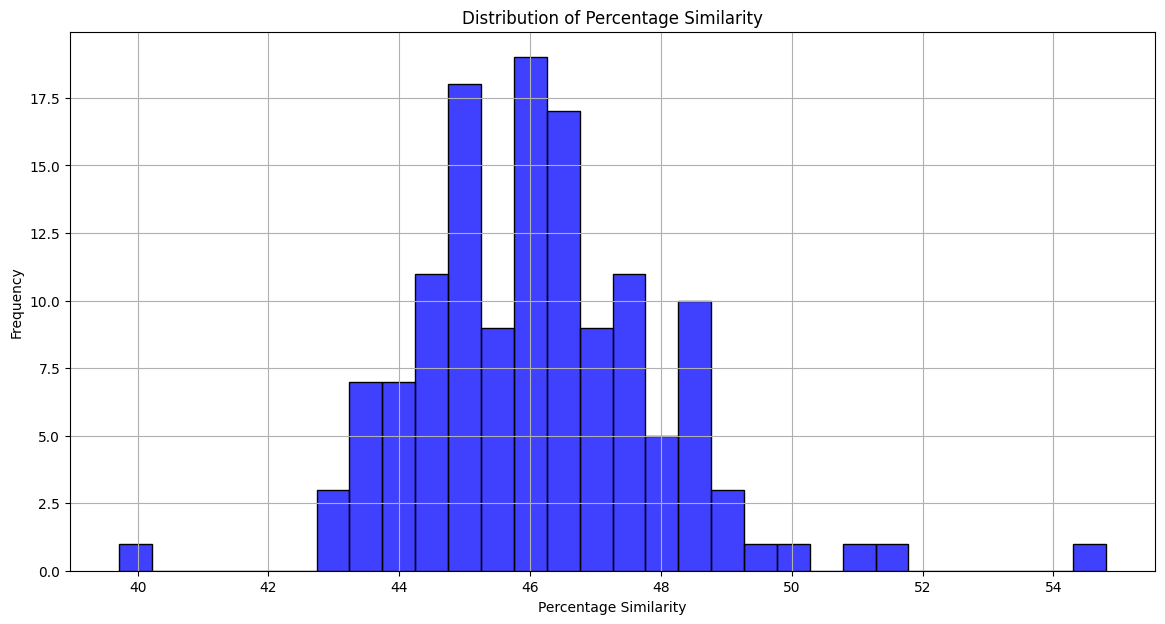

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Provided text
text = """
1/1 [==============================] - 2s 2s/step
1/1 [==============================] - 2s 2s/step
Percentage Similarity (hdm24.png): 47.26%
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm2 (1).png): 45.65%
1/1 [==============================] - 1s 938ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm1 (1).png): 44.83%
1/1 [==============================] - 1s 741ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm136 (1).png): 43.83%
1/1 [==============================] - 1s 976ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm136.png): 43.83%
1/1 [==============================] - 1s 671ms/step
1/1 [==============================] - 1s 611ms/step
Percentage Similarity (hdm135 (1).png): 47.95%
1/1 [==============================] - 1s 627ms/step
1/1 [==============================] - 1s 580ms/step
Percentage Similarity (hdm135.png): 47.95%
1/1 [==============================] - 1s 663ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm134 (1).png): 44.05%
1/1 [==============================] - 1s 949ms/step
1/1 [==============================] - 1s 998ms/step
Percentage Similarity (hdm134.png): 44.05%
1/1 [==============================] - 1s 920ms/step
1/1 [==============================] - 1s 588ms/step
Percentage Similarity (hdm133 (1).png): 47.51%
1/1 [==============================] - 1s 587ms/step
1/1 [==============================] - 1s 602ms/step
Percentage Similarity (hdm133.png): 47.51%
1/1 [==============================] - 1s 591ms/step
1/1 [==============================] - 1s 597ms/step
Percentage Similarity (hdm132 (1).png): 44.76%
1/1 [==============================] - 1s 599ms/step
1/1 [==============================] - 1s 598ms/step
Percentage Similarity (hdm132.png): 44.76%
1/1 [==============================] - 1s 591ms/step
1/1 [==============================] - 1s 597ms/step
Percentage Similarity (hdm131 (1).png): 47.00%
1/1 [==============================] - 1s 595ms/step
1/1 [==============================] - 1s 587ms/step
Percentage Similarity (hdm131.png): 47.00%
1/1 [==============================] - 1s 601ms/step
1/1 [==============================] - 1s 579ms/step
Percentage Similarity (hdm130 (1).png): 47.93%
1/1 [==============================] - 1s 577ms/step
1/1 [==============================] - 1s 587ms/step
Percentage Similarity (hdm130.png): 47.93%
1/1 [==============================] - 1s 835ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm128 (1).png): 45.53%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 946ms/step
Percentage Similarity (hdm128.png): 45.53%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 733ms/step
Percentage Similarity (hdm127 (1).png): 46.08%
1/1 [==============================] - 1s 608ms/step
1/1 [==============================] - 1s 592ms/step
Percentage Similarity (hdm127.png): 46.08%
1/1 [==============================] - 1s 592ms/step
1/1 [==============================] - 1s 574ms/step
Percentage Similarity (hdm126 (1).png): 46.17%
1/1 [==============================] - 1s 586ms/step
1/1 [==============================] - 1s 589ms/step
Percentage Similarity (hdm126.png): 46.17%
1/1 [==============================] - 1s 587ms/step
1/1 [==============================] - 1s 586ms/step
Percentage Similarity (hdm125 (1).png): 46.14%
1/1 [==============================] - 1s 605ms/step
1/1 [==============================] - 1s 592ms/step
Percentage Similarity (hdm125.png): 46.14%
1/1 [==============================] - 1s 583ms/step
1/1 [==============================] - 1s 603ms/step
Percentage Similarity (hdm124 (1).png): 48.87%
1/1 [==============================] - 1s 577ms/step
1/1 [==============================] - 1s 597ms/step
Percentage Similarity (hdm124.png): 48.87%
1/1 [==============================] - 1s 948ms/step
1/1 [==============================] - 1s 967ms/step
Percentage Similarity (hdm123 (1).png): 44.70%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 915ms/step
Percentage Similarity (hdm123.png): 44.70%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 778ms/step
Percentage Similarity (hdm122 (1).png): 46.09%
1/1 [==============================] - 1s 608ms/step
1/1 [==============================] - 1s 583ms/step
Percentage Similarity (hdm122.png): 46.09%
1/1 [==============================] - 1s 603ms/step
1/1 [==============================] - 1s 579ms/step
Percentage Similarity (hdm121 (1).png): 45.84%
1/1 [==============================] - 1s 576ms/step
1/1 [==============================] - 1s 597ms/step
Percentage Similarity (hdm121.png): 45.84%
1/1 [==============================] - 1s 610ms/step
1/1 [==============================] - 1s 581ms/step
Percentage Similarity (hdm120 (1).png): 46.34%
1/1 [==============================] - 1s 600ms/step
1/1 [==============================] - 1s 586ms/step
Percentage Similarity (hdm120.png): 46.34%
1/1 [==============================] - 1s 579ms/step
1/1 [==============================] - 1s 589ms/step
Percentage Similarity (hdm119 (1).png): 43.87%
1/1 [==============================] - 1s 589ms/step
1/1 [==============================] - 1s 581ms/step
Percentage Similarity (hdm119.png): 43.87%
1/1 [==============================] - 1s 848ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm118 (1).png): 48.36%
1/1 [==============================] - 1s 970ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm118.png): 48.36%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm117 (1).png): 49.80%
1/1 [==============================] - 1s 945ms/step
1/1 [==============================] - 1s 900ms/step
Percentage Similarity (hdm117.png): 49.80%
1/1 [==============================] - 1s 593ms/step
1/1 [==============================] - 1s 597ms/step
Percentage Similarity (hdm116 (1).png): 45.10%
1/1 [==============================] - 1s 576ms/step
1/1 [==============================] - 1s 587ms/step
Percentage Similarity (hdm116.png): 45.10%
1/1 [==============================] - 1s 588ms/step
1/1 [==============================] - 1s 577ms/step
Percentage Similarity (hdm115 (1).png): 48.28%
1/1 [==============================] - 1s 583ms/step
1/1 [==============================] - 1s 590ms/step
Percentage Similarity (hdm115.png): 48.28%
1/1 [==============================] - 1s 574ms/step
1/1 [==============================] - 1s 594ms/step
Percentage Similarity (hdm114 (1).png): 45.52%
1/1 [==============================] - 1s 618ms/step
1/1 [==============================] - 1s 991ms/step
Percentage Similarity (hdm114.png): 45.52%
1/1 [==============================] - 1s 967ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm113 (1).png): 46.41%
1/1 [==============================] - 1s 908ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm113.png): 46.41%
1/1 [==============================] - 1s 601ms/step
1/1 [==============================] - 1s 592ms/step
Percentage Similarity (hdm112 (1).png): 46.55%
1/1 [==============================] - 1s 581ms/step
1/1 [==============================] - 1s 594ms/step
Percentage Similarity (hdm112.png): 46.55%
1/1 [==============================] - 1s 587ms/step
1/1 [==============================] - 1s 605ms/step
Percentage Similarity (hdm111 (1).png): 46.27%
1/1 [==============================] - 1s 599ms/step
1/1 [==============================] - 1s 575ms/step
Percentage Similarity (hdm111.png): 46.27%
1/1 [==============================] - 1s 595ms/step
1/1 [==============================] - 1s 587ms/step
Percentage Similarity (hdm110 (1).png): 43.99%
1/1 [==============================] - 1s 592ms/step
1/1 [==============================] - 1s 597ms/step
Percentage Similarity (hdm110.png): 43.99%
1/1 [==============================] - 1s 607ms/step
1/1 [==============================] - 1s 590ms/step
Percentage Similarity (hdm109 (1).png): 47.62%
1/1 [==============================] - 1s 589ms/step
1/1 [==============================] - 1s 962ms/step
Percentage Similarity (hdm109.png): 47.62%
1/1 [==============================] - 1s 993ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm108 (1).png): 45.96%
1/1 [==============================] - 1s 983ms/step
1/1 [==============================] - 1s 957ms/step
Percentage Similarity (hdm108.png): 45.96%
1/1 [==============================] - 1s 587ms/step
1/1 [==============================] - 1s 581ms/step
Percentage Similarity (hdm107 (1).png): 43.66%
1/1 [==============================] - 1s 601ms/step
1/1 [==============================] - 1s 600ms/step
Percentage Similarity (hdm107.png): 43.66%
1/1 [==============================] - 1s 587ms/step
1/1 [==============================] - 1s 589ms/step
Percentage Similarity (hdm106 (1).png): 47.38%
1/1 [==============================] - 1s 603ms/step
1/1 [==============================] - 1s 568ms/step
Percentage Similarity (hdm106.png): 47.38%
1/1 [==============================] - 1s 593ms/step
1/1 [==============================] - 1s 590ms/step
Percentage Similarity (hdm105 (1).png): 44.70%
1/1 [==============================] - 1s 577ms/step
1/1 [==============================] - 1s 592ms/step
Percentage Similarity (hdm105.png): 44.70%
1/1 [==============================] - 1s 584ms/step
1/1 [==============================] - 1s 588ms/step
Percentage Similarity (hdm104 (1).png): 46.37%
1/1 [==============================] - 1s 688ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm104.png): 46.37%
1/1 [==============================] - 1s 972ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm103 (1).png): 46.85%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm103.png): 46.85%
1/1 [==============================] - 1s 642ms/step
1/1 [==============================] - 1s 687ms/step
Percentage Similarity (hdm102 (1).png): 46.51%
1/1 [==============================] - 1s 637ms/step
1/1 [==============================] - 1s 585ms/step
Percentage Similarity (hdm102.png): 46.51%
1/1 [==============================] - 1s 604ms/step
1/1 [==============================] - 1s 602ms/step
Percentage Similarity (hdm101 (1).png): 46.40%
1/1 [==============================] - 1s 603ms/step
1/1 [==============================] - 1s 611ms/step
Percentage Similarity (hdm101.png): 46.40%
1/1 [==============================] - 1s 617ms/step
1/1 [==============================] - 1s 582ms/step
Percentage Similarity (hdm100 (1).png): 47.75%
1/1 [==============================] - 1s 592ms/step
1/1 [==============================] - 1s 620ms/step
Percentage Similarity (hdm100.png): 47.75%
1/1 [==============================] - 1s 599ms/step
1/1 [==============================] - 1s 593ms/step
Percentage Similarity (hdm99 (1).png): 46.23%
1/1 [==============================] - 1s 892ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm99.png): 46.23%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 960ms/step
Percentage Similarity (hdm98 (1).png): 45.16%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 812ms/step
Percentage Similarity (hdm98.png): 45.16%
1/1 [==============================] - 1s 622ms/step
1/1 [==============================] - 1s 587ms/step
Percentage Similarity (hdm97 (1).png): 48.64%
1/1 [==============================] - 1s 580ms/step
1/1 [==============================] - 1s 585ms/step
Percentage Similarity (hdm97.png): 48.64%
1/1 [==============================] - 1s 597ms/step
1/1 [==============================] - 1s 577ms/step
Percentage Similarity (hdm96 (1).png): 46.71%
1/1 [==============================] - 1s 597ms/step
1/1 [==============================] - 1s 589ms/step
Percentage Similarity (hdm96.png): 46.71%
1/1 [==============================] - 1s 588ms/step
1/1 [==============================] - 1s 607ms/step
Percentage Similarity (hdm95 (1).png): 45.92%
1/1 [==============================] - 1s 603ms/step
1/1 [==============================] - 1s 584ms/step
Percentage Similarity (hdm95.png): 45.92%
1/1 [==============================] - 1s 632ms/step
1/1 [==============================] - 1s 588ms/step
Percentage Similarity (hdm94 (1).png): 48.31%
1/1 [==============================] - 1s 905ms/step
1/1 [==============================] - 1s 990ms/step
Percentage Similarity (hdm94.png): 48.31%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 965ms/step
Percentage Similarity (hdm93 (1).png): 47.15%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 847ms/step
Percentage Similarity (hdm93.png): 47.15%
1/1 [==============================] - 1s 592ms/step
1/1 [==============================] - 1s 588ms/step
Percentage Similarity (hdm92 (1).png): 43.54%
1/1 [==============================] - 1s 596ms/step
1/1 [==============================] - 1s 582ms/step
Percentage Similarity (hdm92.png): 43.54%
1/1 [==============================] - 1s 608ms/step
1/1 [==============================] - 1s 575ms/step
Percentage Similarity (hdm91 (1).png): 45.74%
1/1 [==============================] - 1s 598ms/step
1/1 [==============================] - 1s 600ms/step
Percentage Similarity (hdm91.png): 45.74%
1/1 [==============================] - 1s 580ms/step
1/1 [==============================] - 1s 575ms/step
Percentage Similarity (hdm90 (1).png): 48.45%
1/1 [==============================] - 1s 589ms/step
1/1 [==============================] - 1s 571ms/step
Percentage Similarity (hdm90.png): 48.45%
1/1 [==============================] - 1s 585ms/step
1/1 [==============================] - 1s 597ms/step
Percentage Similarity (hdm88 (1).png): 44.25%
1/1 [==============================] - 1s 752ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm88.png): 44.25%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 995ms/step
Percentage Similarity (hdm87 (1).png): 47.49%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 763ms/step
Percentage Similarity (hdm87.png): 47.49%
1/1 [==============================] - 1s 578ms/step
1/1 [==============================] - 1s 593ms/step
Percentage Similarity (hdm86 (1).png): 43.31%
1/1 [==============================] - 1s 595ms/step
1/1 [==============================] - 1s 576ms/step
Percentage Similarity (hdm86.png): 43.31%
1/1 [==============================] - 1s 589ms/step
1/1 [==============================] - 1s 584ms/step
Percentage Similarity (hdm85 (1).png): 44.92%
1/1 [==============================] - 1s 575ms/step
1/1 [==============================] - 1s 583ms/step
Percentage Similarity (hdm85.png): 44.92%
1/1 [==============================] - 1s 583ms/step
1/1 [==============================] - 1s 575ms/step
Percentage Similarity (hdm84 (1).png): 46.26%
1/1 [==============================] - 1s 619ms/step
1/1 [==============================] - 1s 571ms/step
Percentage Similarity (hdm84.png): 46.26%
1/1 [==============================] - 1s 578ms/step
1/1 [==============================] - 1s 599ms/step
Percentage Similarity (hdm83 (1).png): 47.83%
1/1 [==============================] - 1s 872ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm83.png): 47.83%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 972ms/step
Percentage Similarity (hdm82 (1).png): 46.88%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 807ms/step
Percentage Similarity (hdm82.png): 46.88%
1/1 [==============================] - 1s 576ms/step
1/1 [==============================] - 1s 595ms/step
Percentage Similarity (hdm81 (1).png): 44.95%
1/1 [==============================] - 1s 599ms/step
1/1 [==============================] - 1s 575ms/step
Percentage Similarity (hdm81.png): 44.95%
1/1 [==============================] - 1s 589ms/step
1/1 [==============================] - 1s 599ms/step
Percentage Similarity (hdm80 (1).png): 44.83%
1/1 [==============================] - 1s 580ms/step
1/1 [==============================] - 1s 580ms/step
Percentage Similarity (hdm80.png): 44.83%
1/1 [==============================] - 1s 604ms/step
1/1 [==============================] - 1s 578ms/step
Percentage Similarity (hdm79 (1).png): 48.02%
1/1 [==============================] - 1s 610ms/step
1/1 [==============================] - 1s 594ms/step
Percentage Similarity (hdm79.png): 48.02%
1/1 [==============================] - 1s 579ms/step
1/1 [==============================] - 1s 602ms/step
Percentage Similarity (hdm78 (1).png): 44.92%
1/1 [==============================] - 1s 812ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm78.png): 44.92%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 980ms/step
Percentage Similarity (hdm77 (1).png): 47.66%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 847ms/step
Percentage Similarity (hdm77.png): 47.66%
1/1 [==============================] - 1s 585ms/step
1/1 [==============================] - 1s 575ms/step
Percentage Similarity (hdm76 (1).png): 48.79%
1/1 [==============================] - 1s 615ms/step
1/1 [==============================] - 1s 591ms/step
Percentage Similarity (hdm76.png): 48.79%
1/1 [==============================] - 1s 573ms/step
1/1 [==============================] - 1s 590ms/step
Percentage Similarity (hdm75 (1).png): 45.07%
1/1 [==============================] - 1s 590ms/step
1/1 [==============================] - 1s 609ms/step
Percentage Similarity (hdm75.png): 45.07%
1/1 [==============================] - 1s 602ms/step
1/1 [==============================] - 1s 594ms/step
Percentage Similarity (hdm74 (1).png): 46.43%
1/1 [==============================] - 1s 585ms/step
1/1 [==============================] - 1s 604ms/step
Percentage Similarity (hdm74.png): 46.43%
1/1 [==============================] - 1s 594ms/step
1/1 [==============================] - 1s 580ms/step
Percentage Similarity (hdm73 (1).png): 46.74%
1/1 [==============================] - 1s 800ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm73.png): 46.74%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 979ms/step
Percentage Similarity (hdm72 (1).png): 46.68%
1/1 [==============================] - 1s 968ms/step
1/1 [==============================] - 1s 662ms/step
Percentage Similarity (hdm72.png): 46.68%
1/1 [==============================] - 1s 608ms/step
1/1 [==============================] - 1s 615ms/step
Percentage Similarity (hdm71 (1).png): 45.29%
1/1 [==============================] - 1s 584ms/step
1/1 [==============================] - 1s 613ms/step
Percentage Similarity (hdm71.png): 45.29%
1/1 [==============================] - 1s 574ms/step
1/1 [==============================] - 1s 583ms/step
Percentage Similarity (hdm70 (1).png): 43.02%
1/1 [==============================] - 1s 603ms/step
1/1 [==============================] - 1s 587ms/step
Percentage Similarity (hdm70.png): 43.02%
1/1 [==============================] - 1s 601ms/step
1/1 [==============================] - 1s 584ms/step
Percentage Similarity (hdm69 (1).png): 45.88%
1/1 [==============================] - 1s 590ms/step
1/1 [==============================] - 1s 595ms/step
Percentage Similarity (hdm69.png): 45.88%
1/1 [==============================] - 1s 603ms/step
1/1 [==============================] - 1s 609ms/step
Percentage Similarity (hdm68 (1).png): 54.80%
1/1 [==============================] - 1s 968ms/step
1/1 [==============================] - 1s 922ms/step
Percentage Similarity (hdm68.png): 54.80%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 963ms/step
Percentage Similarity (hdm67 (1).png): 49.58%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 568ms/step
Percentage Similarity (hdm67.png): 49.58%
1/1 [==============================] - 1s 608ms/step
1/1 [==============================] - 1s 575ms/step
Percentage Similarity (hdm66 (1).png): 45.03%
1/1 [==============================] - 1s 571ms/step
1/1 [==============================] - 1s 594ms/step
Percentage Similarity (hdm66.png): 45.03%
1/1 [==============================] - 1s 584ms/step
1/1 [==============================] - 1s 619ms/step
Percentage Similarity (hdm65 (1).png): 48.29%
1/1 [==============================] - 1s 594ms/step
1/1 [==============================] - 1s 596ms/step
Percentage Similarity (hdm65.png): 48.29%
1/1 [==============================] - 1s 579ms/step
1/1 [==============================] - 1s 595ms/step
Percentage Similarity (hdm64 (1).png): 46.73%
1/1 [==============================] - 1s 586ms/step
1/1 [==============================] - 1s 582ms/step
Percentage Similarity (hdm64.png): 46.73%
1/1 [==============================] - 1s 600ms/step
1/1 [==============================] - 1s 667ms/step
Percentage Similarity (hdm63 (1).png): 44.17%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 972ms/step
Percentage Similarity (hdm63.png): 44.17%
1/1 [==============================] - 1s 974ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm62 (1).png): 48.53%
1/1 [==============================] - 1s 910ms/step
1/1 [==============================] - 1s 582ms/step
Percentage Similarity (hdm62.png): 48.53%
1/1 [==============================] - 1s 582ms/step
1/1 [==============================] - 1s 598ms/step
Percentage Similarity (hdm61 (1).png): 46.84%
1/1 [==============================] - 1s 605ms/step
1/1 [==============================] - 1s 575ms/step
Percentage Similarity (hdm61.png): 46.84%
1/1 [==============================] - 1s 604ms/step
1/1 [==============================] - 1s 607ms/step
Percentage Similarity (hdm60 (1).png): 46.76%
1/1 [==============================] - 1s 584ms/step
1/1 [==============================] - 1s 620ms/step
Percentage Similarity (hdm60.png): 46.76%
1/1 [==============================] - 1s 598ms/step
1/1 [==============================] - 1s 573ms/step
Percentage Similarity (hdm59 (1).png): 47.31%
1/1 [==============================] - 1s 597ms/step
1/1 [==============================] - 1s 602ms/step
Percentage Similarity (hdm59.png): 47.31%
1/1 [==============================] - 1s 587ms/step
1/1 [==============================] - 1s 887ms/step
Percentage Similarity (hdm58 (1).png): 48.29%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm58.png): 48.29%
1/1 [==============================] - 1s 925ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm57 (1).png): 48.29%
1/1 [==============================] - 1s 724ms/step
1/1 [==============================] - 1s 593ms/step
Percentage Similarity (hdm57.png): 48.29%
1/1 [==============================] - 1s 614ms/step
1/1 [==============================] - 1s 762ms/step
Percentage Similarity (hdm56 (1).png): 44.48%
1/1 [==============================] - 1s 911ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm56.png): 44.48%
1/1 [==============================] - 1s 992ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm55 (1).png): 44.48%
1/1 [==============================] - 1s 603ms/step
1/1 [==============================] - 1s 580ms/step
Percentage Similarity (hdm55.png): 44.48%
1/1 [==============================] - 1s 585ms/step
1/1 [==============================] - 1s 717ms/step
Percentage Similarity (hdm54 (1).png): 42.89%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 960ms/step
Percentage Similarity (hdm54.png): 42.89%
1/1 [==============================] - 1s 993ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm53 (1).png): 46.63%
1/1 [==============================] - 1s 856ms/step
1/1 [==============================] - 1s 598ms/step
Percentage Similarity (hdm53.png): 46.63%
1/1 [==============================] - 1s 586ms/step
1/1 [==============================] - 1s 594ms/step
Percentage Similarity (hdm52 (1).png): 39.72%
1/1 [==============================] - 1s 590ms/step
1/1 [==============================] - 1s 586ms/step
Percentage Similarity (hdm52.png): 39.72%
1/1 [==============================] - 1s 604ms/step
1/1 [==============================] - 1s 597ms/step
Percentage Similarity (hdm51 (1).png): 46.50%
1/1 [==============================] - 1s 574ms/step
1/1 [==============================] - 1s 596ms/step
Percentage Similarity (hdm51.png): 46.50%
1/1 [==============================] - 1s 598ms/step
1/1 [==============================] - 1s 575ms/step
Percentage Similarity (hdm50 (1).png): 47.32%
1/1 [==============================] - 1s 592ms/step
1/1 [==============================] - 1s 591ms/step
Percentage Similarity (hdm50.png): 47.32%
1/1 [==============================] - 1s 591ms/step
1/1 [==============================] - 1s 945ms/step
Percentage Similarity (hdm49 (1).png): 45.76%
1/1 [==============================] - 1s 987ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm49.png): 45.76%
1/1 [==============================] - 1s 924ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm48 (1).png): 47.88%
1/1 [==============================] - 1s 813ms/step
1/1 [==============================] - 1s 583ms/step
Percentage Similarity (hdm48.png): 47.88%
1/1 [==============================] - 1s 626ms/step
1/1 [==============================] - 1s 586ms/step
Percentage Similarity (hdm47 (1).png): 47.57%
1/1 [==============================] - 1s 583ms/step
1/1 [==============================] - 1s 596ms/step
Percentage Similarity (hdm47.png): 47.57%
1/1 [==============================] - 1s 580ms/step
1/1 [==============================] - 1s 592ms/step
Percentage Similarity (hdm45 (1).png): 46.30%
1/1 [==============================] - 1s 593ms/step
1/1 [==============================] - 1s 593ms/step
Percentage Similarity (hdm45.png): 46.30%
1/1 [==============================] - 1s 599ms/step
1/1 [==============================] - 1s 594ms/step
Percentage Similarity (hdm44 (1).png): 47.70%
1/1 [==============================] - 1s 584ms/step
1/1 [==============================] - 1s 575ms/step
Percentage Similarity (hdm44.png): 47.70%
1/1 [==============================] - 1s 599ms/step
1/1 [==============================] - 1s 962ms/step
Percentage Similarity (hdm43 (1).png): 43.96%
1/1 [==============================] - 1s 979ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm43.png): 43.96%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 965ms/step
Percentage Similarity (hdm42 (1).png): 45.77%
1/1 [==============================] - 1s 598ms/step
1/1 [==============================] - 1s 591ms/step
Percentage Similarity (hdm42.png): 45.77%
1/1 [==============================] - 1s 587ms/step
1/1 [==============================] - 1s 591ms/step
Percentage Similarity (hdm41 (1).png): 44.18%
1/1 [==============================] - 1s 619ms/step
1/1 [==============================] - 1s 598ms/step
Percentage Similarity (hdm41.png): 44.18%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm40 (1).png): 44.72%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm40.png): 44.72%
1/1 [==============================] - 1s 613ms/step
1/1 [==============================] - 1s 919ms/step
Percentage Similarity (hdm39 (1).png): 44.72%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm39.png): 44.72%
1/1 [==============================] - 1s 989ms/step
1/1 [==============================] - 1s 1000ms/step
Percentage Similarity (hdm38 (1).png): 45.62%
1/1 [==============================] - 1s 592ms/step
1/1 [==============================] - 1s 576ms/step
Percentage Similarity (hdm38.png): 45.62%
1/1 [==============================] - 1s 599ms/step
1/1 [==============================] - 1s 593ms/step
Percentage Similarity (hdm37 (1).png): 44.69%
1/1 [==============================] - 1s 578ms/step
1/1 [==============================] - 1s 603ms/step
Percentage Similarity (hdm37.png): 44.69%
1/1 [==============================] - 1s 601ms/step
1/1 [==============================] - 1s 577ms/step
Percentage Similarity (hdm36 (1).png): 48.92%
1/1 [==============================] - 1s 596ms/step
1/1 [==============================] - 1s 585ms/step
Percentage Similarity (hdm36.png): 48.92%
1/1 [==============================] - 1s 588ms/step
1/1 [==============================] - 1s 593ms/step
Percentage Similarity (hdm35 (1).png): 46.72%
1/1 [==============================] - 1s 589ms/step
1/1 [==============================] - 1s 593ms/step
Percentage Similarity (hdm35.png): 46.72%
1/1 [==============================] - 1s 774ms/step
1/1 [==============================] - 1s 967ms/step
Percentage Similarity (hdm34 (1).png): 45.96%
1/1 [==============================] - 1s 983ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm34.png): 45.96%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 865ms/step
Percentage Similarity (hdm33 (1).png): 48.64%
1/1 [==============================] - 1s 609ms/step
1/1 [==============================] - 1s 600ms/step
Percentage Similarity (hdm33.png): 48.64%
1/1 [==============================] - 1s 577ms/step
1/1 [==============================] - 1s 599ms/step
Percentage Similarity (hdm32 (1).png): 43.60%
1/1 [==============================] - 1s 608ms/step
1/1 [==============================] - 1s 587ms/step
Percentage Similarity (hdm32.png): 43.60%
1/1 [==============================] - 1s 593ms/step
1/1 [==============================] - 1s 576ms/step
Percentage Similarity (hdm31 (1).png): 44.59%
1/1 [==============================] - 1s 578ms/step
1/1 [==============================] - 1s 592ms/step
Percentage Similarity (hdm31.png): 44.59%
1/1 [==============================] - 1s 574ms/step
1/1 [==============================] - 1s 578ms/step
Percentage Similarity (hdm30 (1).png): 44.89%
1/1 [==============================] - 1s 600ms/step
1/1 [==============================] - 1s 576ms/step
Percentage Similarity (hdm30.png): 44.89%
1/1 [==============================] - 1s 890ms/step
1/1 [==============================] - 1s 967ms/step
Percentage Similarity (hdm29 (1).png): 46.76%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 946ms/step
Percentage Similarity (hdm29.png): 46.76%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 615ms/step
Percentage Similarity (hdm28 (1).png): 45.98%
1/1 [==============================] - 1s 587ms/step
1/1 [==============================] - 1s 590ms/step
Percentage Similarity (hdm28.png): 45.98%
1/1 [==============================] - 1s 576ms/step
1/1 [==============================] - 1s 596ms/step
Percentage Similarity (hdm27 (1).png): 44.84%
1/1 [==============================] - 1s 610ms/step
1/1 [==============================] - 1s 572ms/step
Percentage Similarity (hdm27.png): 44.84%
1/1 [==============================] - 1s 606ms/step
1/1 [==============================] - 1s 589ms/step
Percentage Similarity (hdm25 (1).png): 45.02%
1/1 [==============================] - 1s 598ms/step
1/1 [==============================] - 1s 595ms/step
Percentage Similarity (hdm25.png): 45.02%
1/1 [==============================] - 1s 604ms/step
1/1 [==============================] - 1s 581ms/step
Percentage Similarity (hdm23 (1).png): 45.48%
1/1 [==============================] - 1s 598ms/step
1/1 [==============================] - 1s 611ms/step
Percentage Similarity (hdm23.png): 45.48%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 956ms/step
Percentage Similarity (hdm11 (1).png): 44.96%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 997ms/step
Percentage Similarity (hdm11.png): 44.96%
1/1 [==============================] - 1s 858ms/step
1/1 [==============================] - 1s 580ms/step
Percentage Similarity (hdm46 (1).png): 44.55%
1/1 [==============================] - 1s 602ms/step
1/1 [==============================] - 1s 598ms/step
Percentage Similarity (hdm46.png): 44.55%
1/1 [==============================] - 1s 588ms/step
1/1 [==============================] - 1s 600ms/step
Percentage Similarity (hdm89 (1).png): 44.92%
1/1 [==============================] - 1s 597ms/step
1/1 [==============================] - 1s 571ms/step
Percentage Similarity (hdm89.png): 44.92%
1/1 [==============================] - 1s 588ms/step
1/1 [==============================] - 1s 573ms/step
Percentage Similarity (hdm129 (1).png): 45.72%
1/1 [==============================] - 1s 573ms/step
1/1 [==============================] - 1s 600ms/step
Percentage Similarity (hdm129.png): 45.72%
1/1 [==============================] - 1s 606ms/step
1/1 [==============================] - 1s 572ms/step
Percentage Similarity (hdm26.png): 51.05%
1/1 [==============================] - 1s 603ms/step
1/1 [==============================] - 1s 815ms/step
Percentage Similarity (hdm17.png): 44.29%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm15.png): 43.67%
1/1 [==============================] - 1s 975ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm19.png): 43.22%
1/1 [==============================] - 1s 838ms/step
1/1 [==============================] - 1s 584ms/step
Percentage Similarity (hdm18.png): 47.04%
1/1 [==============================] - 1s 587ms/step
1/1 [==============================] - 1s 604ms/step
Percentage Similarity (hdm20.png): 43.42%
1/1 [==============================] - 1s 598ms/step
1/1 [==============================] - 1s 588ms/step
Percentage Similarity (hdm16.png): 44.81%
1/1 [==============================] - 1s 603ms/step
1/1 [==============================] - 1s 584ms/step
Percentage Similarity (hdm22.png): 43.69%
1/1 [==============================] - 1s 577ms/step
1/1 [==============================] - 1s 595ms/step
Percentage Similarity (hdm21.png): 46.02%
1/1 [==============================] - 1s 596ms/step
1/1 [==============================] - 1s 572ms/step
Percentage Similarity (hdm14.png): 46.98%
1/1 [==============================] - 1s 607ms/step
1/1 [==============================] - 1s 589ms/step
Percentage Similarity (hdm13.png): 45.83%
1/1 [==============================] - 1s 574ms/step
1/1 [==============================] - 1s 848ms/step
Percentage Similarity (hdm12.png): 45.98%
1/1 [==============================] - 1s 1s/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm10.png): 45.95%
1/1 [==============================] - 1s 930ms/step
1/1 [==============================] - 1s 1s/step
Percentage Similarity (hdm9.png): 45.69%
1/1 [==============================] - 1s 814ms/step
1/1 [==============================] - 1s 596ms/step
Percentage Similarity (hdm8.png): 45.00%
1/1 [==============================] - 1s 593ms/step
1/1 [==============================] - 1s 578ms/step
Percentage Similarity (hdm7.png): 51.48%
1/1 [==============================] - 1s 586ms/step
1/1 [==============================] - 1s 587ms/step
Percentage Similarity (hdm6.png): 44.75%
1/1 [==============================] - 1s 578ms/step
1/1 [==============================] - 1s 589ms/step
Percentage Similarity (hdm5.png): 46.11%
1/1 [==============================] - 1s 586ms/step
1/1 [==============================] - 1s 588ms/step
Percentage Similarity (hdm3.png): 45.95%
1/1 [==============================] - 1s 590ms/step
1/1 [==============================] - 1s 587ms/step
Percentage Similarity (hdm2.png): 45.65%
1/1 [==============================] - 1s 578ms/step
1/1 [==============================] - 1s 582ms/step
Percentage Similarity (hdm1.png): 44.83%
All comparisons completed.
"""

# Step 1: Extract the percentage similarity and corresponding file names
pattern = re.compile(r'Percentage Similarity \((.*?)\): (\d+\.\d+)%')
matches = pattern.findall(text)

# Create a DataFrame
data = pd.DataFrame(matches, columns=['filename', 'similarity'])
data['similarity'] = data['similarity'].astype(float)

# Step 2: Remove duplicates based on file names (ignoring the "(1)" part)
data['filename'] = data['filename'].str.replace(r' \(\d+\)', '', regex=True)
data = data.drop_duplicates(subset='filename')

# Step 3: Calculate the median and average of the remaining percentages
median_similarity = data['similarity'].median()
average_similarity = data['similarity'].mean()

# Print median and average
print(f"Median Similarity: {median_similarity:.2f}%")
print(f"Average Similarity: {average_similarity:.2f}%")

# Step 4: Create a bar chart to visualize the distribution of the percentage similarity
plt.figure(figsize=(14, 7))
sns.histplot(data['similarity'], bins=30, kde=False, color='blue')
plt.title('Distribution of Percentage Similarity')
plt.xlabel('Percentage Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
